## Урок 2. Кейс 1. Преобразование признаков

Обозначения:<br>
p - глубина истории, сколько измерений назад учитываем в моделях<br>
h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

#### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .
#### 2. Оцените ошибку модели из п.1.
#### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [65]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

In [66]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [67]:
def split_data_b(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [68]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [69]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Text(0.5, 1.0, 'PJME_MW')

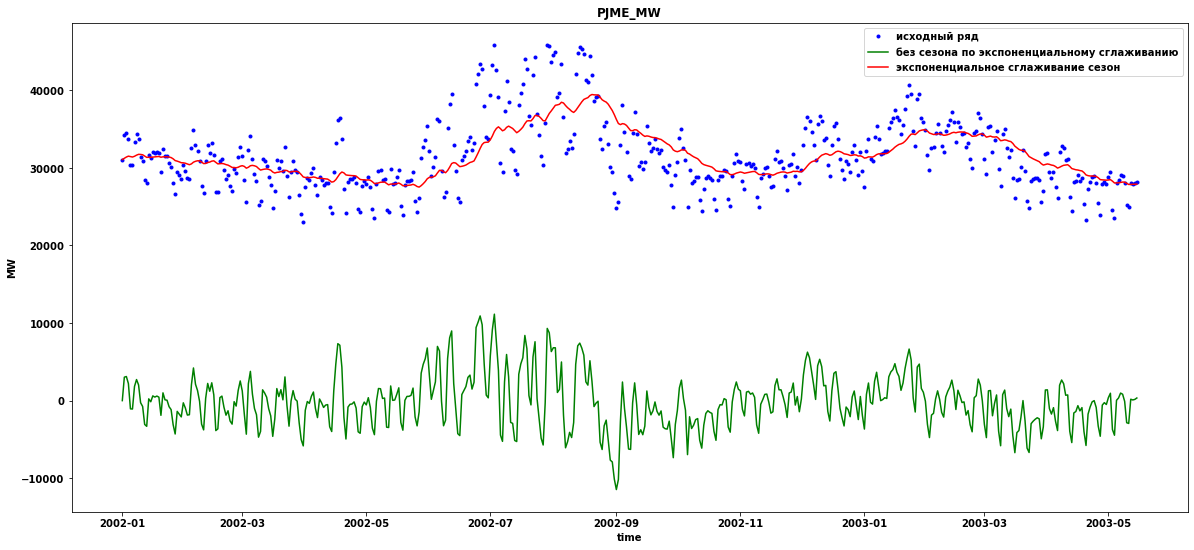

In [70]:
d_data = data.resample('D').mean()
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.05)

plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b', label='исходный ряд')
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");
plt.plot(d_data.index[:500], data_exp_1[:500], color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [71]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) - data_exp_1))
DF_ = sm.tsa.stattools.adfuller(data_seson_free.iloc[:,0], regression = 'ctt')
DF_

(-8.365362138577241,
 4.282974615026078e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Ряд стационарен

Этап feature engineering

In [72]:
data_exp_1 = pd.DataFrame(data = data_exp_1, index = d_data.index)
df = pd.DataFrame(data_exp_1)

# добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]

df.head()

C:\Users\rseme\.conda\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,0.0


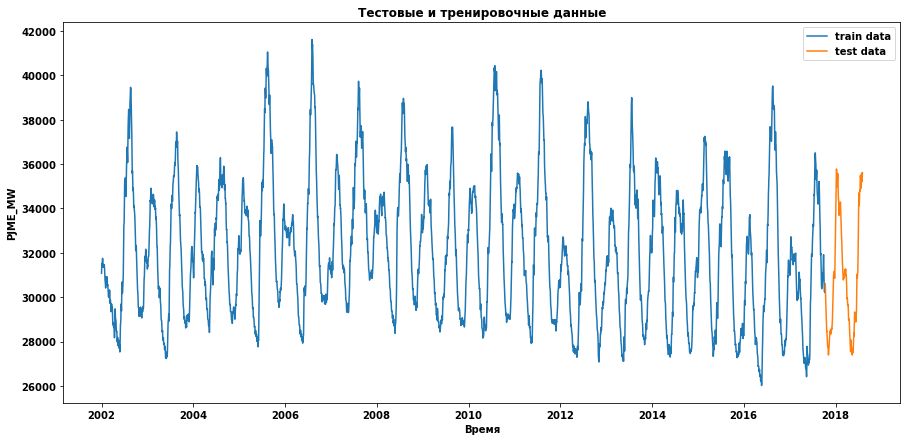

In [73]:
# Разобъём данные
train_b, test_b = split_data_b(df, '10-10-2017')

# h = 1
X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('PJME_MW')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

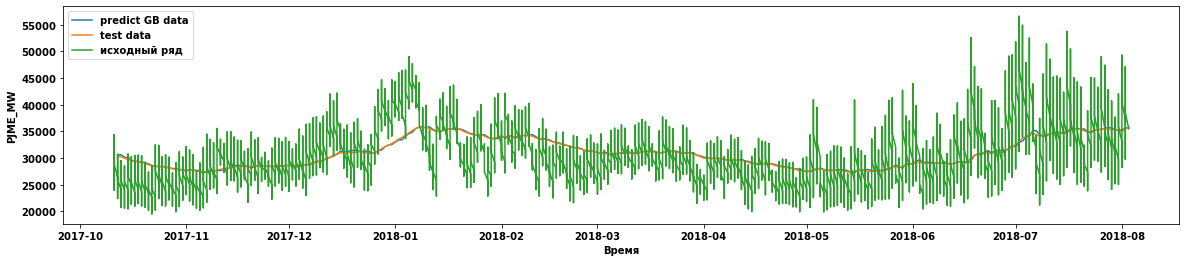

ошибка градиентного бустинга :   0.4536011762843374 %


In [74]:
# Обучим модель
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('PJME_MW')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(b_s.loc['2017-10-11':].index, b_s.loc['2017-10-11':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

# Оценим ошибку для h = 1
er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

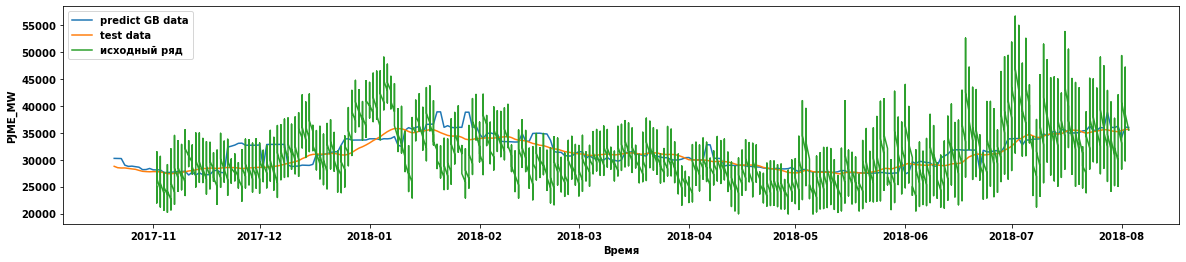

ошибка градиентного бустинга :   3.2711580175524215 %


In [75]:
# h = 10
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('PJME_MW')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(b_s.loc['2017-11-02':].index, b_s.loc['2017-11-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

# Оценим ошибку для h = 10
er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Вывод: с увеличением горизонта прогноза ошибка модели возврастает, что логично.

#### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):
а) Изменение температуры за окном :).<br>
б) Количество денег, которые тратят покупатели в интернет магазине.<br>
в) Вес растущего котенка.<br>
г) Прирост объема деревьев в лесу от времени

#### Ответ

а) Не стационарный, сезонный. Т.к. в зависимости от времени года средняя температура будет выше или ниже, плюс расброс температуры в разное время года может быть разным.<br>
б) Не стационарный, сезонный, тренд. Сезонность зависит от праздников. Может наблюдаться тренд, если магазин развивается или наоборот.<br>
в) Не стационарный, тренд. Т.к. вес растёт.<br>
г) В ботанике не силён, но скорее всего будет стационарный ряд, если предположить что деревья растут равномерно.